# LAB14

Acknowledgments: I used ChatGPT to understand coding error messages and ask for explanations on Q3 Part G


In [2]:
## Torch libraries
import torch
import torchvision
import numpy as np

In [3]:
## Load efficient net b0 weights
efnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

## Set up efficientnet_b0 model using those weights
efnet_model = torchvision.models.efficientnet_b0(weights = efnet_weights)

In [4]:
## Efficient net preprocessing transforms
print(efnet_weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [5]:
### Read flattened, processed data
import pandas as pd
fash_mnist = pd.read_csv("https://remiller1450.github.io/data/fashion_mnist_train.csv")

## Train-test split
from sklearn.model_selection import train_test_split
train_fash, test_fash = train_test_split(fash_mnist, test_size=0.1, random_state=5)

### Separate the label column (outcome)
train_y = train_fash['y']
train_X = train_fash.drop(['y'], axis=1)
test_y = test_fash['y']
test_X = test_fash.drop(['y'], axis=1)

### Convert to numpy array then reshape to 900 by 28 by 28
mnist_unflattened = train_X.to_numpy()
mnist_unflattened = mnist_unflattened.reshape(900,28,28)

## Convert to tensor
mnist_tensor = torch.from_numpy(mnist_unflattened)
mnist_tensor =  torch.unsqueeze(mnist_tensor, dim=1)

## Transform to proper input shape (duplicate the single color channel to produce 3 channels)
new_mnist_tensors = mnist_tensor.expand(-1, 3, -1, -1)

## Store in DataLoader
from torch.utils.data import DataLoader, TensorDataset
y_tensor = torch.Tensor(train_y)
train_loader = DataLoader(TensorDataset(new_mnist_tensors.type(torch.FloatTensor), y_tensor.type(torch.LongTensor)), batch_size=100)

### Q1

In [6]:
#### Part A
import torch
import torchvision
import torch.nn as nn

print(efnet_model)



EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

The kernel size is 3x3.

#### Part B
Dropout() randomly zeroes some of the elements of the input tensor with probability p during training.

Because different neurons get dropped each time, the network can’t depend too much on any one of them. This helps prevent overfitting and makes the model generalize better.

### Q2

In [7]:

## Loop through each parameter and set `requires_grad` to false
for param in efnet_model.features.parameters():
    param.requires_grad = False
    

## Replace the existing "classifier" layer with our own creation
efnet_model.classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features=1280, out_features=10, bias=True))

#### Part A

A linear layer with 1280 inputs and 10 outputs has $1280\cdot 10=12800$ weights and 
10 biases. The only part of the model that will learn new parameters is the new final layer, because everything in the features portion is frozen.

#### Part B

avgpool performs a fixed operation and has no parameters, so freezing it is unnecessary.

### Q3

In [8]:
## Hyperparams
epochs = 100
lrate = 0.1

## Cost Function
from torch import nn
cost_fn = nn.CrossEntropyLoss()

## Network model
torch.manual_seed(7) # For reproduction purposes (should be minor since only the last layers are randomly initialized)
net = efnet_model

## Optimizer (using ADAM, a more flexible algorithm than SGD this time)
optimizer = torch.optim.Adam(net.parameters(), lr=lrate)

## Initial values for cost tracking
track_cost = np.zeros(epochs)
cur_cost = 0.0

## Loop through the data
for epoch in range(epochs):
    
    cur_cost = 0.0
    correct = 0.0
    
    ## train_loader is iterable and keeps track of batch numbers
    for i, data in enumerate(train_loader, 0):
        
        ## The input tensor and labels tensor for the current batch
        inputs, labels = data
        
        ## Clear the gradient from the previous batch
        optimizer.zero_grad()
        
        ## Provide the input tensor into the network to get outputs
        outputs = net(inputs)
        
        ## Calculate the cost for the current batch
        ## nn.Softmax is used because net outputs prediction scores and our cost function expects probabilities and labels
        cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)
        
        ## Calculate the gradient
        cost.backward()
        
        ## Update the model parameters using the gradient
        optimizer.step()
        
        ## Track the current cost (accumulating across batches)
        cur_cost += cost.item()
    
    ## Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    # print(f"Epoch: {epoch} Cost: {cur_cost}")

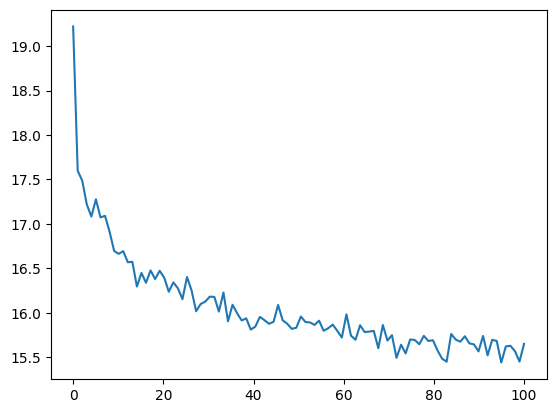

In [9]:
## Print the cost curve
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()

In [10]:
#### Part A

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms


path = "C:/Users/kimin/Documents/STA395/cats_dogs/"



img_names = os.listdir(path)

images = np.empty(shape = (150, 64, 64, 3))
for idx, name in enumerate(img_names):
    img_name = path + name
    image = plt.imread(img_name)
    images[idx] = image


classes = [1, 0]
labels = np.repeat(classes, [50, 100], axis = 0)


from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    images, labels, test_size = 0.25, random_state = 5
)

import torch
from torch.utils.data import TensorDataset, DataLoader


train_X_tensor = torch.from_numpy(train_X)
train_X_tensor = torch.movedim(train_X_tensor, source = 3, destination = 1)
train_X_tensor = train_X_tensor.type(torch.FloatTensor)

train_y_tensor = torch.from_numpy(train_y).type(torch.LongTensor)


train_loader = DataLoader(
    TensorDataset(train_X_tensor, train_y_tensor),
    batch_size = 28,
    shuffle = True
)


In [11]:
#### Part B
from torchvision import transforms

data_transforms = transforms.Compose([
        transforms.GaussianBlur(kernel_size = (5,5), sigma = (0.1, 5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((0, 180))
])


In [12]:
#### Part C
#According to example in part 4


efnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efnet_model = torchvision.models.efficientnet_b0(weights = efnet_weights)


for param in efnet_model.features.parameters():
    param.requires_grad = False


efnet_model.classifier = torch.nn.Sequential(
    torch.nn.Linear(1280, 2)
)


net = efnet_model
epochs = 100
lrate  = 0.001
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lrate)

track_cost = np.zeros(epochs)


for epoch in range(epochs):
    
    cur_cost = 0.0
    for inputs, labels in train_loader:
        
        inputs = data_transforms(inputs)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)
        cost.backward()
        optimizer.step()
        
        cur_cost += cost.item()
    
    track_cost[epoch] = cur_cost


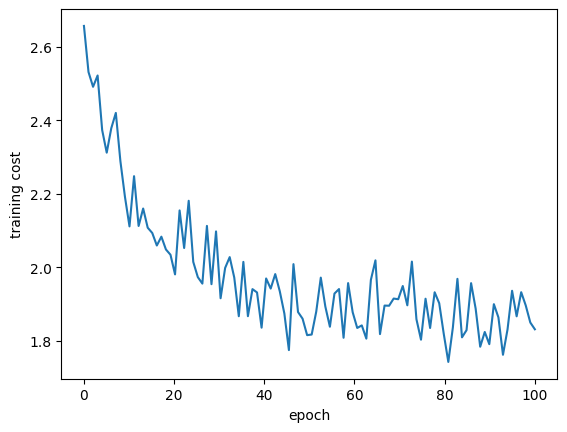

In [13]:
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.xlabel("epoch")
plt.ylabel("training cost")
plt.show()


In [14]:
#### Part D

correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

train_accuracy = correct / total
print(train_accuracy)


0.8660714285714286


In [15]:
test_X_tensor = torch.from_numpy(test_X)
test_X_tensor = torch.movedim(test_X_tensor, source = 3, destination = 1)
test_X_tensor = test_X_tensor.type(torch.FloatTensor)

test_y_tensor = torch.from_numpy(test_y).type(torch.LongTensor)

from torch.utils.data import TensorDataset, DataLoader

test_loader = DataLoader(
    TensorDataset(test_X_tensor, test_y_tensor),
    batch_size = 28,
    shuffle = False
)


correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(test_accuracy)


0.868421052631579


In [16]:
#### Part E


for param in net.features.parameters():
    param.requires_grad = True


epochs_ft = 100
lrate_ft  = 0.00001

cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lrate_ft)

track_cost_ft = np.zeros(epochs_ft)


for epoch in range(epochs_ft):
    
    cur_cost = 0.0
    
    for inputs, labels in train_loader:
    
        inputs = data_transforms(inputs)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        cost = cost_fn(nn.Softmax(dim = 1)(outputs), labels)
        cost.backward()
        optimizer.step()
        
        cur_cost += cost.item()
    
    track_cost_ft[epoch] = cur_cost


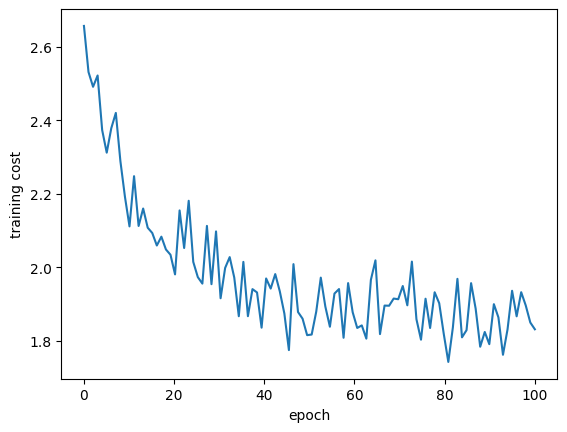

In [17]:
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.xlabel("epoch")
plt.ylabel("training cost")
plt.show()


In [18]:
#### Part F

## Training 
correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct / total)


0.8839285714285714


In [19]:
## Testing 
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct / total)


0.8157894736842105


In [20]:
#### Part G

epochs = 100
lrate  = 0.00001

cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lrate)

track_cost     = np.zeros(epochs)
track_val_cost = np.zeros(epochs)

for epoch in range(epochs):
    
    cur_cost = 0.0
    val_cur_cost = 0.0
    
    for inputs, labels in train_loader:
        
        inputs = data_transforms(inputs)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        cost = cost_fn(nn.Softmax(dim = 1)(outputs), labels)
        cost.backward()
        optimizer.step()
        
        cur_cost += cost.item()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = net(inputs)
            val_cost = cost_fn(nn.Softmax(dim = 1)(outputs), labels)
            val_cur_cost += val_cost.item()
    
    track_cost[epoch]     = cur_cost
    track_val_cost[epoch] = val_cur_cost



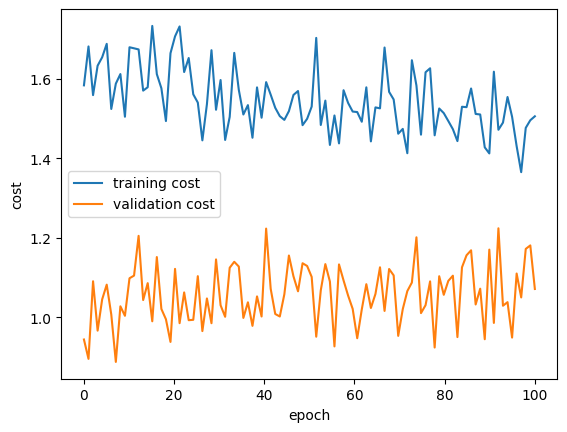

In [21]:
x = np.linspace(0, epochs, epochs)
plt.plot(x, track_cost, label = "training cost")
plt.plot(x, track_val_cost, label = "validation cost")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.legend()
plt.show()
